In [8]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

d1 = pd.read_csv('data/train.csv')
testdata = pd.read_csv('data/test.csv')

In [9]:
from sklearn.compose import ColumnTransformer
from functon_scripts.CustomEstimators import DropColumns, EmbarkedImputer
from functon_scripts.SpecialImputers import DiscreteVar, ImputeAge, ImputeFare
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

labels = d1.Survived
data = d1.copy()
data = data.drop('Survived', axis=1)

cols = data.columns.drop(['Embarked', 'Age', 'Sex', 'Fare'])
fare_bins = [-1, 5, 10, 35, 100, np.inf]
age_bins = [0, 18, 32, np.inf] # more on this later
clean_1 = ColumnTransformer([
    ('drp', DropColumns(drop_ix=[0, 2, 5, 6]), cols),
    ('ohe', OneHotEncoder(), ['Sex']),
    ('dAge', DiscreteVar(bins=age_bins), ['Age']),
    ('dFare', DiscreteVar(bins=fare_bins), ['Fare']),
    ('EmbImp', EmbarkedImputer(), ['Embarked'])
])

clean_and_impute = Pipeline([
    ('clean', clean_1),
    ('fimp', ImputeFare()),
    ('agimp', ImputeAge())
])

In [10]:
Pclass_ix = np.s_[:, 0]
SibSp_ix = np.s_[:, 1]
Parch_ix = np.s_[:, 2]
Sex_ix = np.s_[:, 3:5]
female_ix = np.s_[:, 3]
male_ix = np.s_[:, 4]
Age_ix = np.s_[:, 5]
Fare_ix = np.s_[:, 6]
Embarked_ix = np.s_[:, 7:10]

In [11]:
from sklearn.metrics import f1_score
from functon_scripts.weighted_scorer import WeightedScorer

def weight_rule(X, y):
    gender_survivor_group = pd.Series(3 * X[female_ix] + X[male_ix] + y)
    weights = [0.2 if x in (1, 4) else 0.3 for x in gender_survivor_group]
    return np.array(weights)

weighted_f1 = WeightedScorer(f1_score, rule=weight_rule, sign=1, kwargs={})

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

labels = d1.Survived
data = d1.drop('Survived', axis=1)

clean_data = clean_and_impute.fit_transform(data)
gender_survivor_group = pd.Series(3 * clean_data[:, 3] + clean_data[:, 4] + labels)

stt = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=91)
train_ix, val_ix = next(stt.split(data, labels, groups=gender_survivor_group))
train, train_label = data.iloc[train_ix], labels.iloc[train_ix]
val, val_label = data.iloc[val_ix], labels.iloc[val_ix]

In [13]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import joblib

xgb = XGBClassifier()
params = [
    {'n_estimators': np.arange(45, 55, 2), 
     'reg_lambda': np.arange(0.4, 0.6, 0.05),
     'eta': np.arange(0.1, 0.3, 0.05) 
    }
]
clean_train = clean_and_impute.fit_transform(train)
grids = GridSearchCV(xgb, params, cv=4, scoring=weighted_f1, return_train_score=True)
grids.fit(clean_train, train_label.to_numpy())

joblib.dump(grids.best_estimator_, 'models/xgb_final.pkl')
grids.best_params_

{'eta': 0.15000000000000002, 'n_estimators': 53, 'reg_lambda': 0.5}

0.6734503345299441

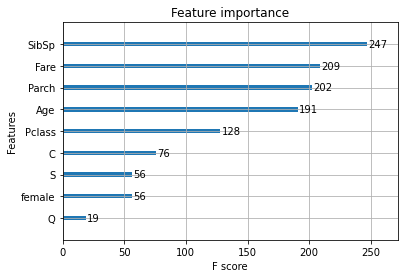

In [14]:
from xgboost import plot_importance

grids.best_estimator_.get_booster().feature_names = ['Pclass', 'SibSp', 'Parch', 'female', 'male', 'Age', 'Fare', 'C', 'Q', 'S']
plot_importance(grids.best_estimator_)
grids.best_score_

In [28]:
from sklearn.metrics import accuracy_score

xgb = XGBClassifier(n_estimators=50, eta=0.15, reg_lambda=0.4).fit(clean_train, train_label.to_numpy())
clean_val = clean_and_impute.fit_transform(val).astype(int)
# clean_val.columns = ['Pclass', 'SibSp', 'Parch', 'female', 'male', 'Age', 'Fare', 'C', 'Q', 'S']
val_predict_xgb = xgb.predict(clean_val)

accuracy_score(val_predict_xgb, val_label)

0.8444444444444444

In [60]:
from sklearn.svm import SVC

svm = SVC()
params = [
    {'C': np.arange(5, 7, 0.2)}
]
clean_train = clean_and_impute.fit_transform(train)
grids = GridSearchCV(svm, params, cv=4, scoring=weighted_f1, return_train_score=True)
grids.fit(clean_train, train_label.to_numpy())

joblib.dump(grids.best_estimator_, 'models/svm_final.pkl')
grids.best_params_

{'C': 6.400000000000001}

In [85]:
svm = SVC(C=6.4, probability=True).fit(clean_train, train_label.to_numpy())
clean_val = clean_and_impute.fit_transform(val).astype(int)
# clean_val.columns = ['Pclass', 'SibSp', 'Parch', 'female', 'male', 'Age', 'Fare', 'C', 'Q', 'S']
val_predict_svm = svm.predict(clean_val)

accuracy_score(val_predict_svm, val_label)

0.8333333333333334

In [64]:
grids.best_score_

0.4993885011647625

In [79]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
params = [
    {'n_neighbors': np.arange(8, 13, 1), 
     'weights': ['uniform', 'distance']
    }
]
clean_train = clean_and_impute.fit_transform(train)
grids = GridSearchCV(knn, params, cv=4, scoring=weighted_f1, return_train_score=True)
grids.fit(clean_train, train_label.to_numpy())

joblib.dump(grids.best_estimator_, 'models/knn_final.pkl')
grids.best_params_

{'n_neighbors': 12, 'weights': 'distance'}

In [80]:
knn = KNeighborsClassifier(n_neighbors=12, weights='distance').fit(clean_train, train_label.to_numpy())
clean_val = clean_and_impute.fit_transform(val).astype(int)
# clean_val.columns = ['Pclass', 'SibSp', 'Parch', 'female', 'male', 'Age', 'Fare', 'C', 'Q', 'S']
val_predict_knn = knn.predict(clean_val)

accuracy_score(val_predict_knn, val_label)

0.8555555555555555

AttributeError: 'StratifiedShuffleSplit' object has no attribute '__slots__'